In [1]:
from sklearn.base import BaseEstimator, TransformerMixin

import os
from pathlib import Path
import random
import unicodedata
import nltk
from gensim.corpora import Dictionary
from gensim.matutils import sparse2full
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

class GensimVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, path=None):
        self.path = path
        self.id2word = None
#         self.load()

    def load(self):
        if os.path.exists(self.path):
            self.id2word = Dictionary.load(self.path)

    def save(self):
        self.id2word.save(self.path)

    def fit(self, documents, labels=None):
        self.id2word = Dictionary(documents)
        self.save()
        return self

    def transform(self, documents):
        for document in documents:
            docvec = self.id2word.doc2bow(document)
            yield sparse2full(docvec, len(self.id2word))

In [2]:
class MyCorpus:
    def __init__(self, filenames):
        self.filenames = filenames
            
    def __iter__(self):
        for file in filenames:
            p = Path('txt-human') / file
            doc = p.read_text()
            yield doc

filenames = random.choices(os.listdir('txt-human'), k=10)
corpus = MyCorpus(filenames)
filenames

['20002982_human.txt',
 '20002304_human.txt',
 '20005582_human.txt',
 '20008562_human.txt',
 '20011180_human.txt',
 '20012702_human.txt',
 '20009834_human.txt',
 '20002178_human.txt',
 '20007649_human.txt',
 '20003791_human.txt']

In [3]:
corpus

In [4]:
class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for sentence in document
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return [
            self.normalize(document)
            for document in documents
        ]
            

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', GensimVectorizer()),
    ('bayes', MultinomialNB()),
])

In [6]:
from sklearn.model_selection import KFold

class CorpusLoader:
    
    def __init__(self, reader, folds=10, shuffle=True, categories=None):
        self.reader = reader
        self.folds = KFold(n_splits=folds, shuffle=shuffle)
        self.files = np.asarray(self.reader.fileids(categories=categories))
        
    def fileids(self, idx=None):
        if idx is None:
            return self.files
        return self.files[idx]
    
    def documents(self, idx=None):
        for fileid in self.fileids(idx):
            yield list(self.reader.docs(fileids=[fileid]))
            
    def labels(self, idx=None):
        return [
            self.reader.categories(fileids=[fileid])
            for fileid in self.fileids(idx)
        ]
    
    def __iter__(self):
        for train_index, test_index in self.folds.split(self.files):
            X_train = self.documents(train_index)
            y_train = self.labels(train_index)
            
            X_test = self.documents(test_index)
            y_test = self.labels(test_index)
            
            yield X_train, X_test, y_train, y_test
            
            

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

def identity(words):
    return words


def create_pipeline(estimator, reduction=False):
    steps = [
        ('normalize', TextNormalizer()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False
        ))
    ]
    
    if reduction:
        steps.append((
            'reduction', TruncatedSVD(n_components=10000)
        ))
        
    steps.append(('classifier', estimator))
    return Pipeline(steps)

In [8]:
from nltk.cluster import KMeansClusterer
import nltk

class KMeansClusters(BaseEstimator, TransformerMixin):
    def __init__(self, k=7):
        self.k = k
        self.distance = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(self.k, self.distance, avoid_empty_clusters=True)
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        return self.model.cluster(documents, assign_clusters=True)
    
    

In [9]:
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

def stupid_tokenize(docs):
    for doc in docs:
        yield [
            pos_tag(wordpunct_tokenize(sent))
            for sent in sent_tokenize(doc)
        ]

new_corpus = list(stupid_tokenize(corpus))

In [10]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, language='English'):
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()
    
    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )
    
    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for sentence in document
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
    
    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)
        
        return self.lemmatizer.lemmatize(token, tag)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, documents):
        return [' '.join(self.normalize(doc)) for doc in documents]
            

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

class OneHotVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.vectorizer = CountVectorizer(binary=True)
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        freqs = self.vectorizer.fit_transform(documents)
        return [freq.toarray()[0] for freq in freqs]

In [12]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('norm', TextNormalizer()),
    ('vect', OneHotVectorizer()),
    ('clusters', KMeansClusters(k=7))
])


In [13]:
clusters = model.fit_transform(new_corpus)

In [14]:
for idx, cluster in enumerate(clusters):
    print('Document {} assigned to cluster {}'.format(filenames[idx], cluster))

Document 20002982_human.txt assigned to cluster 5
Document 20002304_human.txt assigned to cluster 4
Document 20005582_human.txt assigned to cluster 0
Document 20008562_human.txt assigned to cluster 4
Document 20011180_human.txt assigned to cluster 2
Document 20012702_human.txt assigned to cluster 4
Document 20009834_human.txt assigned to cluster 0
Document 20002178_human.txt assigned to cluster 6
Document 20007649_human.txt assigned to cluster 3
Document 20003791_human.txt assigned to cluster 1


In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
def identity(words):
    return words

class SklearnTopicModels:
    
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', CountVectorizer(tokenizer=identity,
                                    preprocessor=None, lowercase=False)),
            ('model', LatentDirichletAllocation(n_components=self.n_components)),
        ])
        
    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model

    def get_topics(self, n=25):
        vectorizer = self.model.named_steps['vect']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()

        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n-1):-1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
        return topics

In [17]:
lda = SklearnTopicModels()
lda.fit_transform(new_corpus)


C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('norm', TextNormalizer(language=None)),
                ('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\...
                                 vocabulary=None)),
                ('model',
                 LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                                           evaluate_every=-1,
                                           learning_decay=0.7,
                                           learning_method='batch',
 

In [18]:
topics = lda.get_topics()
for topic, terms in topics.items():
    print('Topic #{}:'.format(topic+1))
    print(terms)
    break

Topic #1:
['~', 'k', '=', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'z', 'm', 'n', 'o', 'p', 'q', 'r']


In [19]:
class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model (for now).
        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")

        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull

        self.load()

    def load(self):

        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel([self.lexicon.doc2bow(doc) for doc in documents], id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.tfidf[self.lexicon.doc2bow(document)]
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())

In [20]:
from gensim.sklearn_api import ldamodel

In [21]:
class GensimTopicModels:
    
    def __init__(self, num_topics=50):
        self.num_topics = num_topics
        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', GensimTfidfVectorizer()),
            ('model', ldamodel.LdaTransformer(num_topics=self.num_topics))
        ])
        
    def fit(self, documents):
        self.model.fit(documents)
        return self.model

In [22]:
# gensim_lda = GensimTopicModels()
# gensim_lda.fit(new_corpus)

NameError: name 'TfidfModel' is not defined

In [24]:
lda = gensim_lda.model.named_steps['model'].gensim_model
print(lda.show_topics())

NameError: name 'gensim_lda' is not defined

In [25]:
# from operator import itemgetter
# def get_topics(vectorized_corpus, model):
#     topics = [
#         max(model[doc], key=itemgetter(1))[0]
#         for doc in vectorized_corpus
#     ]
#     return topics

# coropus = [
#     gensim_lda.model.named_steps['vect'].lexicon.doc2bow(doc)
#     for doc in gensim_lda.model.named_steps['norm'].transform(new_corpus)
# ]

# topics = get_topics(corpus, lda)

# for topic, doc in zip(topics, docs):
#     print('Topic:{}'.format(topic))
#     print(doc)

In [26]:
def ngrams(words, n=2):
    for idx in range(len(words)-n+1):
        yield tuple(words[idx:idx+n])

In [27]:
!pip install networkx

In [28]:
import itertools
from nltk import sent_tokenize

def cooccurrence(text, cast):
    possible_pairs = list(itertools.combinations(cast, 2))
    cooccuring = dict.fromkeys(possible_pairs, 0)
    for title, chapter in text['chapters'].items():
        for sent in sent_tokenize(chapter):
            for pair in possible_pairs:
                if pair[0] in sent and pair[1] in sent:
                    cooccuring[pair] += 1
    return cooccuring

In [29]:
import json
import codecs
import networkx as nx
import matplotlib.pyplot as plt

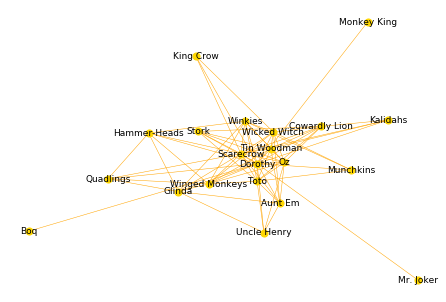

In [30]:
with codecs.open('oz.json', 'r', 'utf-8-sig') as data:
    text = json.load(data)
    cast = text['cast']
    
    G = nx.Graph()
    G.name = 'The Social Network of Oz'
    
    pairs = cooccurrence(text, cast)
    for pair, wgt in pairs.items():
        if wgt > 0:
            G.add_edge(pair[0], pair[1], weight=wgt)
            
    D = nx.ego_graph(G, 'Dorothy')
    edges, weights = zip(*nx.get_edge_attributes(D, 'weight').items())
    
    pos = nx.spring_layout(D, k=.5, iterations=40)
    nx.draw(D, pos, node_color='gold', node_size=50, edgelist=edges,
           width=.5, edge_color='orange', with_labels=True, font_size=9)
    plt.show()

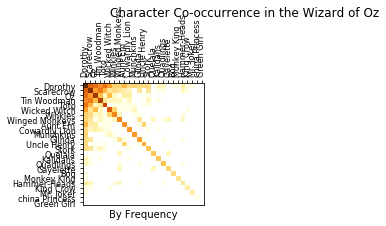

In [31]:
import numpy as np
import matplotlib

def matrix(text, cast):
    mtx = []
    for first in cast:
        row = []
        for second in cast:
            count = 0
            for title, chapter in text['chapters'].items():
                for sent in sent_tokenize(chapter):
                    if first in sent and second in sent:
                        count += 1
            row.append(count)
        mtx.append(row)
    return mtx

mtx = matrix(text,cast)

# Now create the plots
fig, ax = plt.subplots()
fig.suptitle('Character Co-occurrence in the Wizard of Oz', fontsize=12)
fig.subplots_adjust(wspace=.75)

n = len(cast)
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n)

ax1 = plt.subplot(121)
ax1.set_xticks(x_tick_marks)
ax1.set_yticks(y_tick_marks)
ax1.set_xticklabels(cast, fontsize=8, rotation=90)
ax1.set_yticklabels(cast, fontsize=8)
ax1.xaxis.tick_top()
ax1.set_xlabel("By Frequency")
plt.imshow(mtx,
       norm=matplotlib.colors.LogNorm(),
       interpolation='nearest',
       cmap='YlOrBr')

In [32]:
from nltk import word_tokenize

oz_words = []
headings = []
chap_lens = []

for heading, chapter in text['chapters'].items():
    headings.append(heading)
    
    for sent in sent_tokenize(chapter):
        for word in word_tokenize(sent):
            oz_words.append(word)
    chap_lens.append(len(oz_words))
    
chap_starts = [0] + chap_lens[:-1]
chap_marks = list(zip(chap_starts, headings))

In [33]:
cast[:5]

['Dorothy', 'Scarecrow', 'Oz', 'Tin Woodman', 'Toto']

In [34]:
cast.reverse()
points = []
for y in range(len(cast)):
    for x in range(len(oz_words)):
        if len(cast[y].split()) == 1:
            if cast[y] == oz_words[x]:
                points.append((x, y))
        else:
            if cast[y] == ' '.join((oz_words[x-1], oz_words[x])):
                points.append((x,y))
                
if points:
    x, y = list(zip(*points))
    
else:
    x = y = ()

In [35]:
points[:5]

[(42389, 1), (42065, 2), (42214, 2), (42288, 2), (25504, 3)]

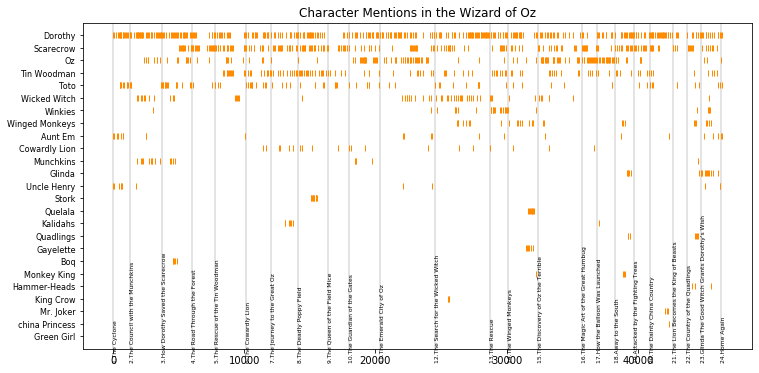

In [36]:
# Create the plot
fig, ax = plt.subplots(figsize=(12,6))
# Add vertical lines labeled for each chapter start
for chap in chap_marks:
    plt.axvline(x=chap[0], linestyle='-',
        color='gainsboro')
    plt.text(chap[0], -2, chap[1], size=6, rotation=90)
# Plot the character mentions
plt.plot(x, y, "|", color="darkorange", scalex=.1)
plt.tick_params(
    axis='x', which='both', bottom='off', labelbottom='off'
)
plt.yticks(list(range(len(cast))), cast, size=8)
plt.ylim(-1, len(cast))
plt.title("Character Mentions in the Wizard of Oz")
plt.show()

In [37]:
from nltk import pos_tag, word_tokenize
from yellowbrick.text.postag import PosTagVisualizer


pie = """
    In a small saucepan, combine sugar and eggs
    until well blended. Cook over low heat, stirring
    constantly, until mixture reaches 160° and coats
    the back of a metal spoon. Remove from the heat.
    Stir in chocolate and vanilla until smooth. Cool
    to lukewarm (90°), stirring occasionally. In a small
    bowl, cream butter until light and fluffy. Add cooled
    chocolate mixture; beat on high speed for 5 minutes
    or until light and fluffy. In another large bowl,
    beat cream until it begins to thicken. Add
    confectioners' sugar; beat until stiff peaks form.
    Fold into chocolate mixture. Pour into crust. Chill
    for at least 6 hours before serving. Garnish with
    whipped cream and chocolate curls if desired.
    """

tokens = word_tokenize(pie)
tagged = pos_tag(tokens)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [39]:
# visualizer = PosTagVisualizer()
# visualizer.transform(tagged)

# print(' '.join((visualizer.colorize(token, color)
#                 for color, token in visualizer.tagged)))
# print('\n')

In [40]:
headlines = ['FDA approves gene therapy',
             'Gene therapy reduces tumor growth',
             'FDA recalls pacemakers']

In [41]:
import networkx as nx
from nltk.corpus import wordnet as wn

In [48]:
def graph_synsets(terms, pos=wn.NOUN, depth=2):
    G = nx.Graph(
        name='WordNet Synsets Graph for {}'.format(', '.join(terms)), depth=depth)
    def add_term_links(G, term, current_depth):
        for syn in wn.synsets(term):
            for name in syn.lemma_names():
                G.add_edge(term, name)
                if current_depth < depth:
                    add_term_links(G, name, current_depth+1)
    
    for term in terms:
        add_term_links(G, term, 0)
        
    return G

In [49]:
G = graph_synsets(['trinket'])
nx.info(G)

'Name: WordNet Synsets Graph for trinket\nType: Graph\nNumber of nodes: 25\nNumber of edges: 49\nAverage degree:   3.9200'

In [50]:
def draw_text_graph(G):
    pos = nx.spring_layout(G, scale=18)
    nx.draw_networkx_nodes(
        G, pos, node_color='white', linewidths=0, node_size=500
    )
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color='lightgrey')
    plt.tick_params(
        axis='both',       # changes apply to both the x- and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # turn off ticks along bottom edge
        left='off',        # turn off ticks along left edge
        labelbottom='off', # turn off labels along bottom edge
        labelleft='off')   # turn off labels along left edge

    plt.show()

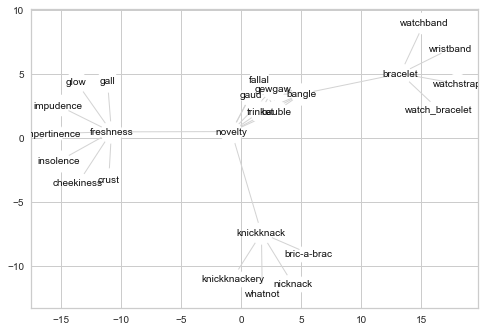

In [51]:
draw_text_graph(G)

In [52]:
for 

In [109]:
import itertools

class EntityPairs(BaseEstimator, TransformerMixin):
    def __init__(self):
        super(EntityPairs, self).__init__()
        
    def pairs(self, document):
#         print(document)
        return list(itertools.permutations(set(document), 2))
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        return [self.pairs(document) for document in documents]
        

class GraphExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.G = nx.Graph()
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            for first, second in document:
                if (first, second) in self.G.edges():
                    self.G.edges[(first, second)]['weight'] += 1
                else:
                    self.G.add_edge(first, second, weight=1)
                    
        return self.G

In [74]:
all_corpus = []
for doc in corpus:
    all_corpus.append(doc)

In [80]:
import spacy
nlp = spacy.load('en_core_web_sm')

GOOD_ENTS = ['PERSON', 'NORP', 'FACILITY', 'ORG', 'GPE', 'LOC',
             'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LANGUAGE']

def entities(sent):
    doc = nlp(sent)
    for ent in doc.ents:
        #  filter out non social entities
        if ent.label_ in GOOD_ENTS:
            return ent.text
        else:
            pass

In [104]:
my_doc = []
for doc in all_corpus:
    sents = sent_tokenize(doc)
    new_sents = []
    for sent in sents:
        value = entities(sent)
        if value:
            new_sents.append(value)
    my_doc.append(new_sents)

In [110]:
graph = Pipeline([
    ('pairs', EntityPairs()),
    ('graph', GraphExtractor())
])

G = graph.fit_transform(my_doc)
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 178\nNumber of edges: 2709\nAverage degree:  30.4382'

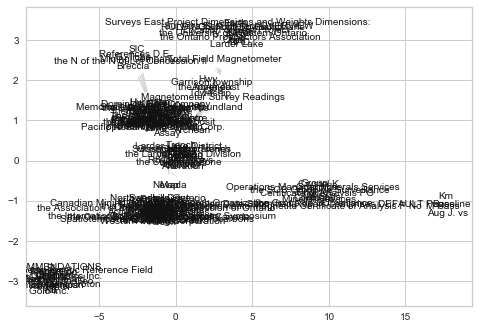

In [111]:
draw_text_graph(G)

In [116]:
oz_corpus = list(text['chapters'].values())
len(oz_corpus)

24

In [117]:
my_doc = []
for doc in oz_corpus:
    sents = sent_tokenize(doc)
    new_sents = []
    for sent in sents:
        value = entities(sent)
        if value:
            new_sents.append(value)
    my_doc.append(new_sents)

In [119]:
graph = Pipeline([
    ('pairs', EntityPairs()),
    ('graph', GraphExtractor())
])

G = graph.fit_transform(my_doc)
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 93\nNumber of edges: 1278\nAverage degree:  27.4839'

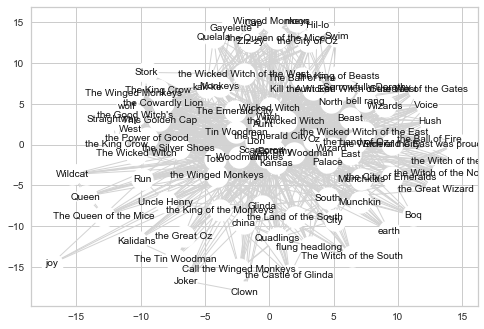

In [120]:
draw_text_graph(G)

In [123]:
import heapq
from operator import itemgetter

def nbest_centrality(G, metrics, n=10):
    nbest = {}
    for name, metric in metrics.items():
        scores = metric(G)
        nx.set_node_attributes(G, name=name, values=scores)

        topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
        nbest[name] = topn
    return nbest
    

In [124]:
centralities = {'degree centrality': nx.degree_centrality,
               'betweenness centrality': nx.betweenness_centrality}

centrality = nbest_centrality(G, centralities, 10)

In [126]:
centrality.items()

dict_items([('degree centrality', [('Dorothy', 1.0), ('Scarecrow', 0.9456521739130435), ('Lion', 0.8913043478260869), ('Kansas', 0.8478260869565217), ('the Emerald City', 0.7391304347826086), ('Oz', 0.717391304347826), ('Witch', 0.7065217391304348), ('the Wicked Witch', 0.7065217391304348), ('Woodman', 0.6413043478260869), ('Winkies', 0.6195652173913043)]), ('betweenness centrality', [('Dorothy', 0.12469767393357228), ('Scarecrow', 0.09744834922844245), ('Lion', 0.08231662867687005), ('Kansas', 0.07421222080836756), ('the Emerald City', 0.046636170001519484), ('Oz', 0.041251373591667535), ('the Wicked Witch', 0.034014293636001856), ('Witch', 0.03342771864068343), ('Woodman', 0.03203137241440689), ('Winkies', 0.02304680449722748)])])

In [125]:
from tabulate import tabulate

for measure, scores in centrality.items():
    print("Rankings for {}:".format(measure))
    print((tabulate(scores, headers=["Top Terms", "Score"])))
    print("")

Rankings for degree centrality:
Top Terms            Score
----------------  --------
Dorothy           1
Scarecrow         0.945652
Lion              0.891304
Kansas            0.847826
the Emerald City  0.73913
Oz                0.717391
Witch             0.706522
the Wicked Witch  0.706522
Woodman           0.641304
Winkies           0.619565

Rankings for betweenness centrality:
Top Terms             Score
----------------  ---------
Dorothy           0.124698
Scarecrow         0.0974483
Lion              0.0823166
Kansas            0.0742122
the Emerald City  0.0466362
Oz                0.0412514
the Wicked Witch  0.0340143
Witch             0.0334277
Woodman           0.0320314
Winkies           0.0230468



In [127]:
H = nx.ego_graph(G, 'Dorothy')

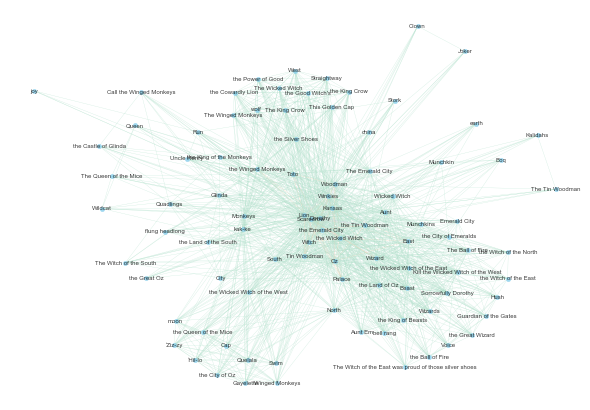

In [129]:
edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())
pos = nx.spring_layout(H, k=0.3, iterations=40)

nx.draw(
    H, pos, node_color="skyblue", node_size=20, edgelist=edges,
    edge_color=weights, width=0.25, edge_cmap=plt.cm.Pastel2,
    with_labels=True, font_size=6, alpha=0.8)
plt.show()